# import libraries

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import itertools  
import math
import itertools
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional
from keras.models import Model
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report 

import tensorflow as tf

Using TensorFlow backend.


## reading data to be trained

In [2]:
# reading data from csv files

path = r'C:\Users\91901\Code Here\CQA\dataset\Subtask B'

train_base = pd.read_csv(os.path.join(path,'TRAIN-BASE.csv'))
test_base = pd.read_csv(os.path.join(path,'TEST-BASE.csv'))
val_base = pd.read_csv(os.path.join(path,'VAL-BASE.csv'))

def read_df(df):
    f = df['feature'].tolist()
    x = df['question'].tolist()
    xx = df['rel_question'].tolist()
    y = df['labels'].tolist()
    return f, x, xx, y

f_train, x_train, xx_train, y_train = read_df(train_base)
f_test, x_test, xx_test, y_test = read_df(test_base)
f_val, x_val, xx_val, y_val = read_df(val_base)

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))
print('\nValidation: ', len(f_val), len(x_val), len(xx_val), len(y_val))


Training:  1958 1958 1958 1958

Testing:  684 684 684 684

Validation:  495 495 495 495


In [3]:
y_test[:5] #checking

['PerfectMatch', 'PerfectMatch', 'Relevant', 'Relevant', 'Relevant']

# let's read and make embeddings for data

In [4]:
# avg_feature_length = avg_question_length = avg_answer_length = 
MAX_SEQUENCE_LENGTH = FINAL_SEQUENCE_LENGTH = 50

In [5]:
# FOR GLOVE VECTORS

def read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM):
    
    with open(os.path.join(GLOVE_DIR, 'glove.6B.'+ str(EMBEDDING_DIM)+'d.txt'),  encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def pretrained_embedding_layer(word_to_vec_map, word_to_index, random_term):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map[random_term].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. 
    # Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

# GLOVE_DIR = 'glove.6B'
# GLOVE_DIR = r'C:\Users\NoBotsHere\codehere\CQACodes\qa_dataset\glove.6B'
GLOVE_DIR = r'C:\Users\91901\Code Here\CQA\dataset\glove.6B'

EMBEDDING_DIM = 50
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, "massage")

In [6]:
def generate_data_for_keras( t1, t2, t3, Y,
#                             X, Y, 
                            word_index):

    t1_sequences = [] #first vector 
    t2_sequences = [] #second vector
    t3_sequences = [] #three vector
    
    for t1_keys in t1:
        t1_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t1_keys.lower().split()])
    
    for t2_keys in t2:
        t2_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t2_keys.lower().split()])
#     print(t2_sequences[:10])
    
    for t3_keys in t3:
        t3_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t3_keys.lower().split()])
#     print(t3_sequences[:10])       
    
    # padding 
    # long sentences truncated to maxlen (last sequences are kept)
    # short sentences padded with 0 (pad are added at begining)
    t1_data = pad_sequences(t1_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')   # if separate features, add dtype = 'object'
    t2_data = pad_sequences(t2_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') 
    t3_data = pad_sequences(t3_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') 

    print('\nShape of feature text data tensor:', t1_data.shape)
    print('\nShape of question1 text data tensor:', t2_data.shape)
    print('\nShape of question2 text data tensor:', t3_data.shape)
 
    
    y = []
    
    for t in Y:    
        if t =='Irrelevant':
            y.append(0)
        elif t =='PerfectMatch':
            y.append(2)
        elif t == 'Relevant':
            y.append(1)
    
    print('\nShape of label data tensor:', np.array(y).shape)
    
    label = np.array(y)
    print('\nlabel data:', label[:10])
    
    return t1_data, t2_data, t3_data, label




# # data for keras layers
#T1 IS FIRST TEXT FEATURE TEXT
#T2 IS QUESTION TEXT 
#T3 IS Related Question TEXT
print('\nTraining: ') 
t1_train, t2_train, t3_train, y_train  = generate_data_for_keras(f_train, x_train, xx_train, y_train, word_to_index)

print('\nTesting: ')
t1_test, t2_test, t3_test, y_test  = generate_data_for_keras(f_test, x_test, xx_test, y_test, word_to_index)

print('\nValidation: ')
t1_val, t2_val, t3_val, y_val  = generate_data_for_keras(f_val, x_val, xx_val, y_val, word_to_index)


print('\nTraining: ', len(t1_train), len(t2_train), len(t3_train), len(y_train)) #must be same
print('\nTesting: ', len(t1_test), len(t2_test), len(t3_test), len(y_test))
print('\nValidation: ', len(t1_val), len(t2_val), len(t3_val), len(y_val))


Training: 

Shape of feature text data tensor: (1958, 50)

Shape of question1 text data tensor: (1958, 50)

Shape of question2 text data tensor: (1958, 50)

Shape of label data tensor: (1958,)

label data: [2 1 0 1 0 0 0 2 0 0]

Testing: 

Shape of feature text data tensor: (684, 50)

Shape of question1 text data tensor: (684, 50)

Shape of question2 text data tensor: (684, 50)

Shape of label data tensor: (684,)

label data: [2 2 1 1 1 1 1 1 0 0]

Validation: 

Shape of feature text data tensor: (495, 50)

Shape of question1 text data tensor: (495, 50)

Shape of question2 text data tensor: (495, 50)

Shape of label data tensor: (495,)

label data: [2 2 2 2 1 1 1 0 2 1]

Training:  1958 1958 1958 1958

Testing:  684 684 684 684

Validation:  495 495 495 495


In [7]:
# DISPLAY training, testing and validation data 

print('------- Training Data -------\n')
for i in range (2):
    print ('Entry:', t1_train[i] , '\n', t2_train[i] , '\n', t3_train[i] , '\nLabel:' , y_train[i], '\n')
      
print('------- Testing Data -------\n')
for i in range (2):
    print ('Entry:', t1_test[i] , '\n', t2_test[i] , '\n', t3_test[i] , '\nLabel:' , y_test[i], '\n')

print('------- Validation Data -------\n')
for i in range (2):
    print ('Entry:', t1_val[i] , '\n', t2_val[i] , '\n', t3_val[i] , '\nLabel:' , y_val[i], '\n')

------- Training Data -------

Entry: [236086 268641 236086 268641      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
 [386432 185457  90548  87972 164328 268641 151349      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
 [192973 357640  57170 285908 185457  90548 148427 320255 236086 268665
 188481      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0     

# Parameters for Training

In [8]:
# define parameters 

nn_units = 128
dropout_inputs = 0.2
recurrent_dropout_inputs = 0.15
batchsize = 64
epochs_count = 100

# Preparing Contextualized Embeddings

In [9]:
%%time

# Prepare embeddings sequences by initializing keras embedding layer with glove embedding values

sequence_input_feat = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='featureLayer')
embedded_feat_sequences = embedding_layer(sequence_input_feat)
      
sequence_input_ques = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='questionLayer')
embedded_ques_sequences = embedding_layer(sequence_input_ques)


sequence_input_ans = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='relQuestionLayer')
embedded_ans_sequences = embedding_layer(sequence_input_ans)

Wall time: 155 ms


In [10]:
%%time

def bilstm_embeddings(embedded_sequences):

   
    n = Bidirectional(LSTM(nn_units, return_sequences= True, 
                            name = 'bilstm_layer', dropout = dropout_inputs, 
                            recurrent_dropout = recurrent_dropout_inputs))(embedded_sequences)

    return n

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_1/concat:0", shape=(None, 50, 256), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(None, 50, 256), dtype=float32)
Tensor("bidirectional_3/concat:0", shape=(None, 50, 256), dtype=float32)
Wall time: 3.94 s


# Model definition for Classification


In [11]:
# default helpful

INPUT_SEQUENCES = [sequence_input_feat, sequence_input_ques, sequence_input_ans]
TRAIN_FIT = [t1_train, t2_train, t3_train]
VAL_FIT = [t1_val, t2_val, t3_val]
TEST_FIT = [t1_test, t2_test, t3_test]

In [12]:
# defining model

def classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES):
    
    # FOR MODEL_1 
    
    FinalLayer = keras.layers.concatenate(inputs = INPUT_EMBEDDINGS, axis = 1)
    FinalLayer = keras.layers.GlobalAveragePooling1D()(FinalLayer)
    predictions = Dense(3, activation = "softmax")(FinalLayer)

    model = Model(inputs = INPUT_SEQUENCES , outputs = predictions)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
    
    model.summary()

    return model

# Common functions - Plot, Evaluate, Save Results

# Training Model

In [13]:
def training_model(model, MODEL_NAME, TRAIN_FIT, VAL_FIT):
    

    callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
    
    checkpoint_path = os.path.join(MODEL_NAME + '_checkpoint.h5')

    modelcheck_acc = ModelCheckpoint(checkpoint_path, 
                                     monitor='acc', mode='max', 
                                    save_best_only = True, verbose=1)

    CALLBACK = [callback, modelcheck_acc]

    history = model.fit(TRAIN_FIT, y_train, 
                            batch_size = batchsize, 
                            epochs = epochs_count, 
                            validation_data = (VAL_FIT, y_val), #replace to t1_val ...so on.
                            callbacks = CALLBACK
                           )
    return history

In [14]:
# into files save
  
# model_directory = "Resulting Model"
# MODEL_SAVING_DIR = os.path.join(path, model_directory)
# os.mkdir(MODEL_SAVING_DIR) 
 
# MODEL_SAVING_DIR = (r'\folder-path')

def save_models(model, MODEL_NAME):
  
    # serialize model to JSON
    model_json = model.to_json()
    with open(MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(MODEL_NAME + ".h5")
    print("\nTHIS MODEL HAS BEEN SAVED TO DIRECTORY: ", os.getcwd())

In [15]:
def plot_graphs(history, string):
    print('training of model')
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [16]:
def plot_both_graphs(history):
    # plot train and validation loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # plot train and validation loss
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model train vs validation acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [17]:
def evaluate_model(model, TEST_FIT):
    # Returns the loss value & metrics values for the model in test mode.
    print("Evaluated on metrics ", model.metrics_names)

    score_loss, score_acc = model.evaluate(TEST_FIT, y_test, batch_size=batchsize)
    print("Test Loss :", score_loss, "Test Accuracy: ", score_acc)

    # MODEL_1 FOR PREDICTIONS 
    model_predictions = model.predict(TEST_FIT)
    print("\npredictions shape is: ", model_predictions.shape)
#     print("\nand few predictions are:\n", model_predictions[:3], "\n\n while original test labels look like: ", y_test[:10])

    #To find the predicted class for each test example, you need to use axis=1
    predicted_class_names = np.argmax(model_predictions, axis = 1)
    print("\n\n Predictions into Class Labels:", predicted_class_names)

    print("\n\n METRICS CLASSIFICATION REPORT IS:\n", classification_report (y_test, np.argmax(model_predictions, axis = 1)))
    
    return model_predictions, predicted_class_names

In [18]:
def result_store(predicted_class_names):
    
    df = pd.DataFrame(columns = ['feature', 'text_1', 'text_2', 'true_label'])
    df['feature'] = f_test
    df['text_1'] = x_test
    df['text_2'] = xx_test
    df['true_label'] = y_test
    df['predicted_label'] = predicted_class_names

    return df

In [19]:
## put into files these 


# df_true_labels = pd.DataFrame(y_test, columns = ['y_test_labels'])
# df_true_labels.y_test_labels.value_counts()
# df_true_labels.head()

# df_pred_labels = pd.DataFrame(predicted_class_names_1, columns = ['y_pred_labels'])
# df_pred_labels.y_pred_labels.value_counts()
# df_pred_labels.head()

# print("no of true labels:\n", df_true_labels.y_test_labels.value_counts())
# print("no of predicted labels:\n", df_pred_labels.y_pred_labels.value_counts())

In [20]:
%%time

# call for stacked embeddings

def stacked_bilstm_embeddings(layer):
    
    for i in range(4):
#         print('run:', i, '--', 'layer-name:', layer)
        layer = Bidirectional(LSTM(nn_units, return_sequences= True, name = 'bilstm_layer', 
                        dropout=dropout_inputs, recurrent_dropout = recurrent_dropout_inputs))(layer)
    
    return layer

Wall time: 0 ns


## Model_bilstm for Classification

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 50)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
relQuestionLayer (InputLayer)   (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

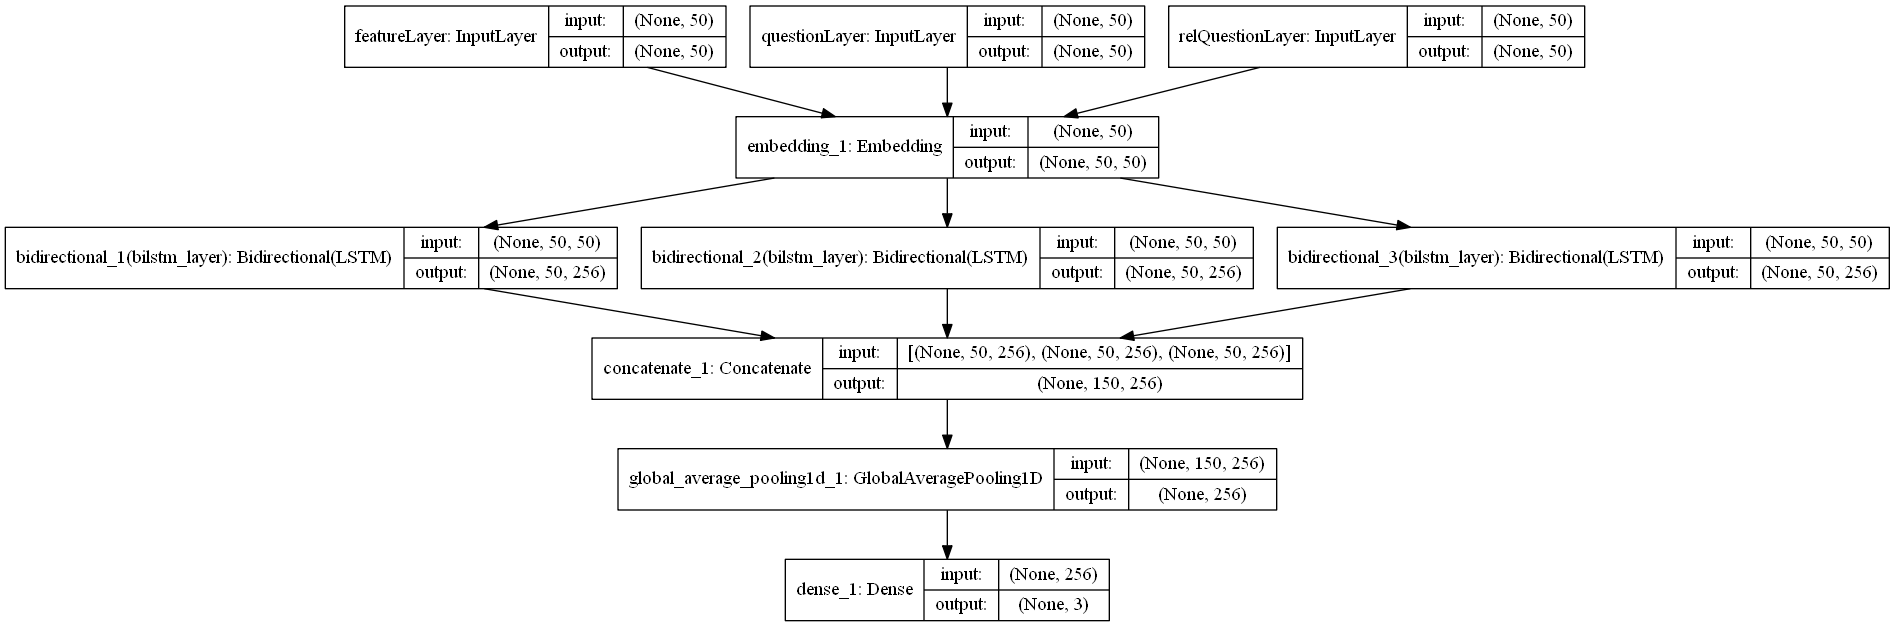

In [21]:
#CUSTOM COLUMNS

INPUT_EMBEDDINGS = [n1, n2, n3]

model_bilstm = classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_bilstm, to_file = 'model_bilstm.png', show_shapes=True, show_layer_names=True)

In [22]:
history_bilstm = training_model(model_bilstm, 'model-bilstm', TRAIN_FIT, VAL_FIT) 
save_models(model_bilstm, 'model-bilstm')

Train on 1958 samples, validate on 495 samples
Epoch 1/100
1958/1958 [==============================] - 11s 5ms/step - loss: 0.8879 - acc: 0.5960 - val_loss: 0.9482 - val_acc: 0.5717

Epoch 00001: acc improved from -inf to 0.59602, saving model to model-bilstm_checkpoint.h5
Epoch 2/100
1958/1958 [==============================] - 5s 3ms/step - loss: 0.8638 - acc: 0.6103 - val_loss: 0.9495 - val_acc: 0.5697

Epoch 00002: acc improved from 0.59602 to 0.61032, saving model to model-bilstm_checkpoint.h5
Epoch 3/100
1958/1958 [==============================] - 5s 3ms/step - loss: 0.8556 - acc: 0.6134 - val_loss: 0.9496 - val_acc: 0.5697

Epoch 00003: acc improved from 0.61032 to 0.61338, saving model to model-bilstm_checkpoint.h5
Epoch 4/100
1958/1958 [==============================] - 5s 3ms/step - loss: 0.8435 - acc: 0.6241 - val_loss: 0.9409 - val_acc: 0.5758

Epoch 00004: acc improved from 0.61338 to 0.62411, saving model to model-bilstm_checkpoint.h5
Epoch 5/100
1958/1958 [============

1958/1958 [==============================] - 5s 3ms/step - loss: 0.6284 - acc: 0.7263 - val_loss: 1.0072 - val_acc: 0.5434

Epoch 00039: acc did not improve from 0.72676
Epoch 40/100
1958/1958 [==============================] - 5s 3ms/step - loss: 0.6247 - acc: 0.7273 - val_loss: 1.0326 - val_acc: 0.5333

Epoch 00040: acc improved from 0.72676 to 0.72727, saving model to model-bilstm_checkpoint.h5
Epoch 41/100
1958/1958 [==============================] - 5s 3ms/step - loss: 0.6231 - acc: 0.7375 - val_loss: 1.0102 - val_acc: 0.5030

Epoch 00041: acc improved from 0.72727 to 0.73749, saving model to model-bilstm_checkpoint.h5
Epoch 42/100
1958/1958 [==============================] - 5s 3ms/step - loss: 0.6291 - acc: 0.7319 - val_loss: 1.0067 - val_acc: 0.5455

Epoch 00042: acc did not improve from 0.73749
Epoch 43/100
1958/1958 [==============================] - 5s 3ms/step - loss: 0.6139 - acc: 0.7426 - val_loss: 1.0356 - val_acc: 0.5434

Epoch 00043: acc improved from 0.73749 to 0.7425

training of model


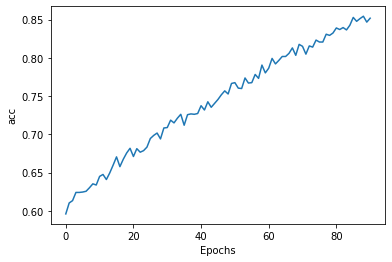

training of model


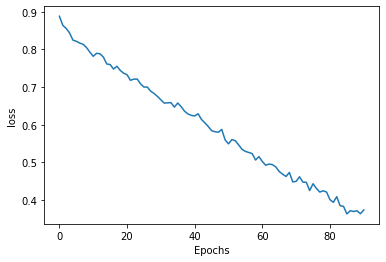

In [23]:
plot_graphs(history_bilstm, 'acc')
plot_graphs(history_bilstm, 'loss')

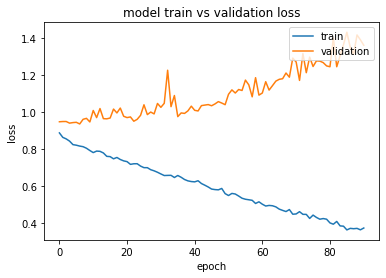

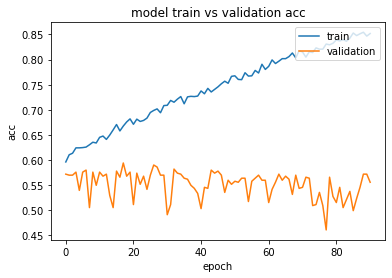

In [24]:
plot_both_graphs(history_bilstm)

In [25]:
# temp if program halts and stops abruptly

# from keras.models import model_from_json

# model_temp = 'model-bilstm.h5'
# model_bilstm = model_temp

# # load json and create model
# json_file = open('model-bilstm.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model-bilstm.h5")
# print("Loaded model from disk")


# # evaluate loaded model on test data
# loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
# model_bilstm = loaded_model

In [26]:
model_predictions_bilstm, predicted_class_names_bilstm = evaluate_model(model_bilstm, TEST_FIT)

Evaluated on metrics  ['loss', 'acc']
684/684 [==============================] - 0s 402us/step
Test Loss : 1.4164618086396603 Test Accuracy:  0.5599415302276611

predictions shape is:  (684, 3)


 Predictions into Class Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1
 1 1 0 2 0 0 0 0 1 0 0 0 0 1 1 1 0 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 2 2 2 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 2 0 1 1 1 0
 1 1 0 0 1 1 0 2 0 0 1 0 0 2 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 2 0 2 0 2 0 0 2 0 1 1 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 1 0 0 0 0

In [27]:
result_bilstm = result_store(predicted_class_names_bilstm)

print("no of true labels:\n", result_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_bilstm.predicted_label.value_counts())

result_bilstm.head()

no of true labels:
 0    454
1    149
2     81
Name: true_label, dtype: int64
no of predicted labels:
 0    510
1    154
2     20
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
0,"""IT Jobs in Qatar Why finding a job in Doha so...","""""how hard is it for you to get a decent payin...",Can somebody tell me how i get a good job in d...,2,0
1,"""IT Jobs in Qatar IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",how hard is it for you to get a decent paying ...,2,0
2,"""IT Jobs in Qatar Are Indians really getting j...","""""how hard is it for you to get a decent payin...",I am coming to qatar in visit visa coming week...,1,0
3,"""IT Jobs in Qatar About the job oppourtinites ...","""""how hard is it for you to get a decent payin...",hi; How about the job oppourtinites are there ...,1,0
4,"""IT Jobs in Qatar requirements to get a job in...","""""how hard is it for you to get a decent payin...",Hi everyone! I born & raised in dubai; my nati...,1,0


In [28]:
results_path = os.getcwd()
result_bilstm.to_csv(os.path.join(results_path,'FQQ-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

# Stacked Model

In [29]:
# define parameters for stacked

nn_units = 64
dropout_inputs = 0.3
recurrent_dropout_inputs = 0.2
batchsize = 32
epochs_count = 80

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_4/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_5/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_6/concat:0", shape=(None, 50, 128), dtype=float32)


In [30]:
stacked_n1 = stacked_bilstm_embeddings(n1)
stacked_n2 = stacked_bilstm_embeddings(n2)
stacked_n3 = stacked_bilstm_embeddings(n3)

print(stacked_n1)
print(stacked_n2)
print(stacked_n3)

Tensor("bidirectional_10/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_14/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_18/concat:0", shape=(None, 50, 128), dtype=float32)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 50)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
relQuestionLayer (InputLayer)   (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

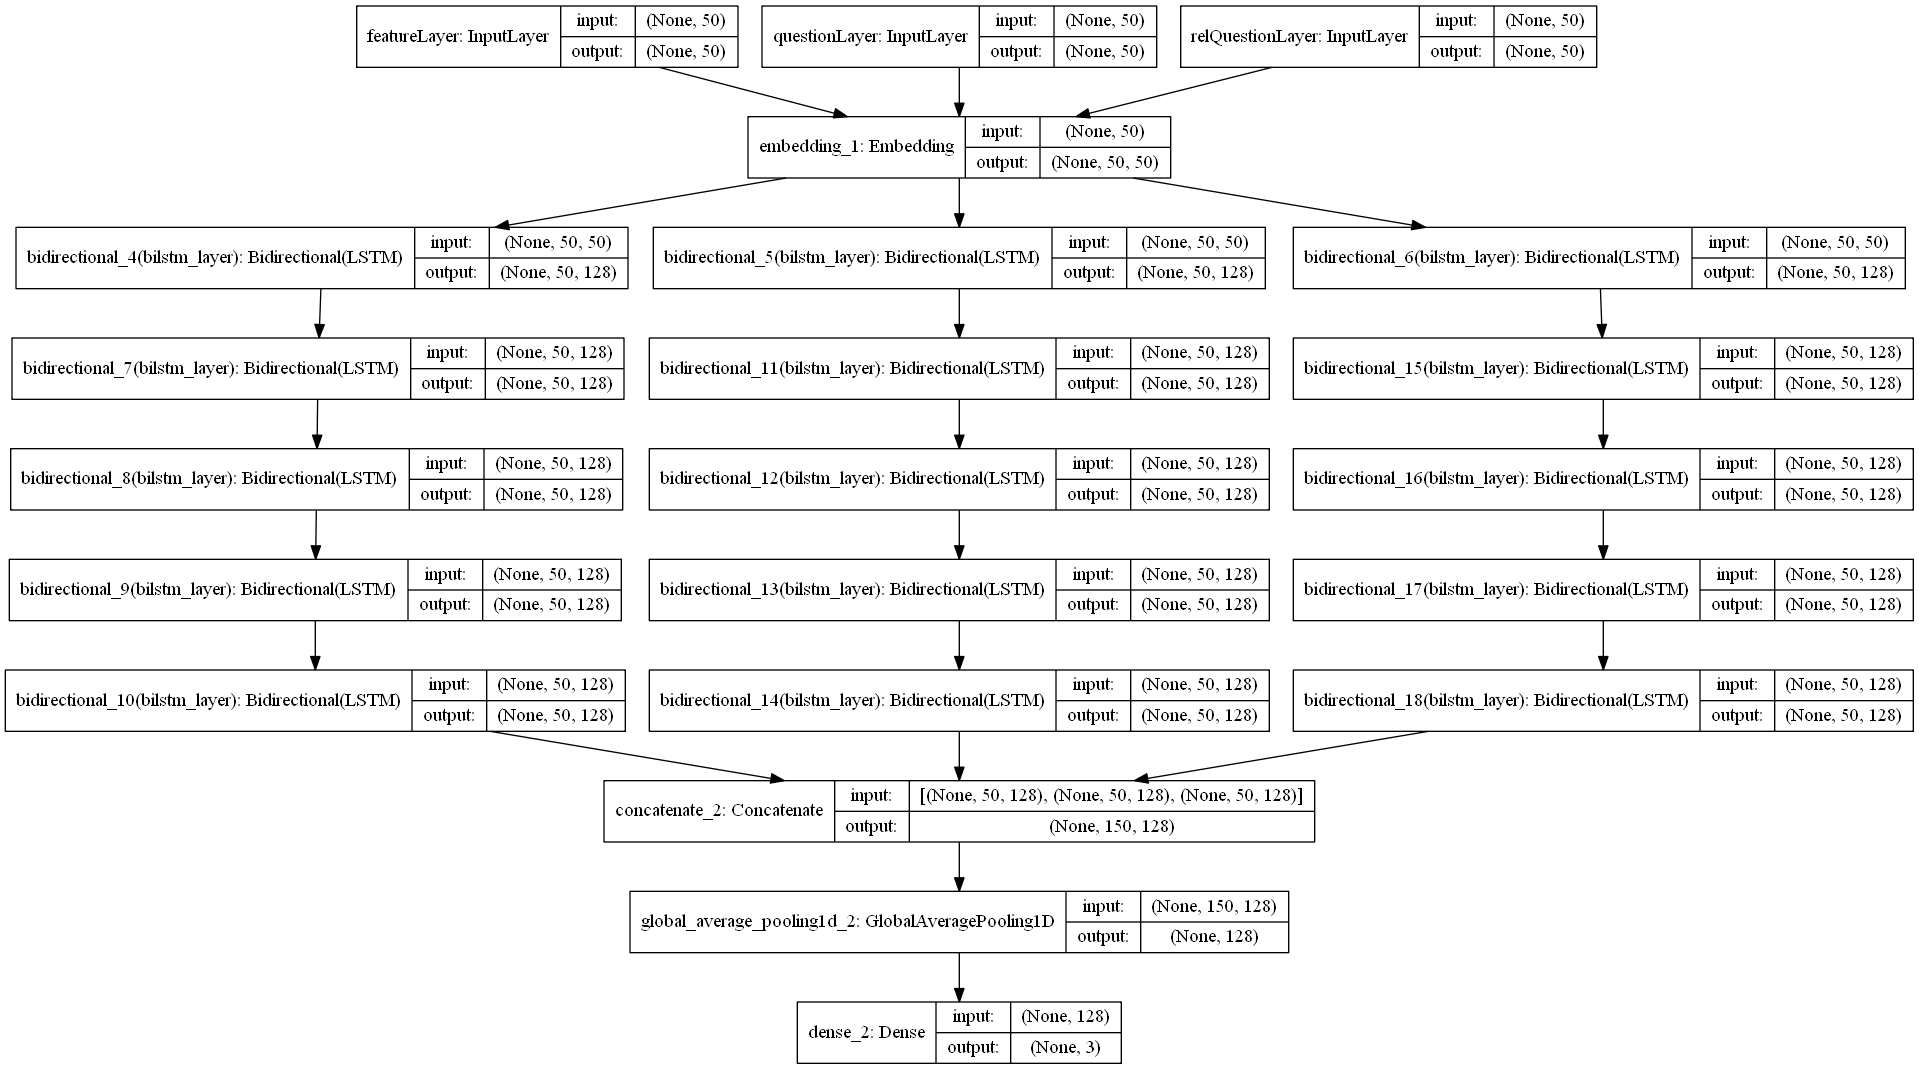

In [31]:
STACKED_EMBEDDINGS = [stacked_n1, stacked_n2, stacked_n3]

model_stacked_bilstm = classification_model(STACKED_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_stacked_bilstm, to_file = 'model_stacked_bilstm.png', show_shapes=True, show_layer_names=True)

In [32]:
history_stacked_bilstm = training_model(model_stacked_bilstm, 'model-stacked-bilstm', TRAIN_FIT, VAL_FIT) 

Train on 1958 samples, validate on 495 samples
Epoch 1/80
1958/1958 [==============================] - 69s 35ms/step - loss: 0.8986 - acc: 0.6011 - val_loss: 1.0156 - val_acc: 0.5717

Epoch 00001: acc improved from -inf to 0.60112, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 2/80
1958/1958 [==============================] - 58s 30ms/step - loss: 0.8742 - acc: 0.6062 - val_loss: 0.9662 - val_acc: 0.5212

Epoch 00002: acc improved from 0.60112 to 0.60623, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 3/80
1958/1958 [==============================] - 58s 30ms/step - loss: 0.8657 - acc: 0.6113 - val_loss: 0.9732 - val_acc: 0.5475

Epoch 00003: acc improved from 0.60623 to 0.61134, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 4/80
1958/1958 [==============================] - 58s 30ms/step - loss: 0.8503 - acc: 0.6073 - val_loss: 1.0243 - val_acc: 0.5717

Epoch 00004: acc did not improve from 0.61134
Epoch 5/80
1958/1958 [==============================] - 

In [33]:
save_models(model_stacked_bilstm, 'model_stacked_bilstm')


THIS MODEL HAS BEEN SAVED TO DIRECTORY:  C:\Users\91901\Code Here\CQA\1 go-to files functions\task-B


training of model


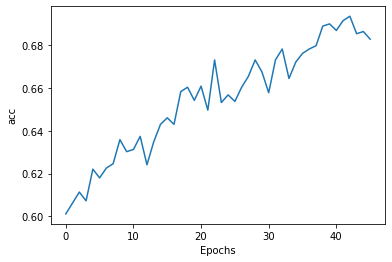

training of model


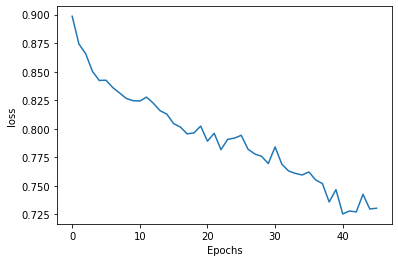

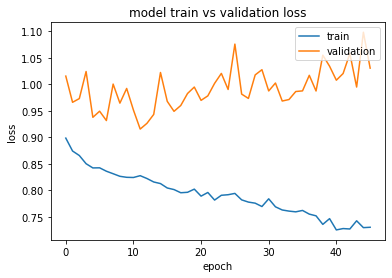

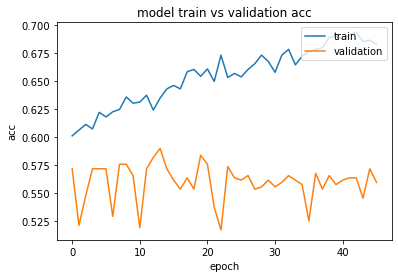

In [34]:
plot_graphs(history_stacked_bilstm, 'acc')
plot_graphs(history_stacked_bilstm, 'loss')
plot_both_graphs(history_stacked_bilstm)

In [35]:
model_predictions_stacked_bilstm, predicted_class_names_stacked_bilstm = evaluate_model(model_stacked_bilstm, TEST_FIT)

Evaluated on metrics  ['loss', 'acc']
684/684 [==============================] - 3s 5ms/step
Test Loss : 0.9792346623208787 Test Accuracy:  0.6359649300575256

predictions shape is:  (684, 3)


 Predictions into Class Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 2 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2

In [36]:
result_stacked_bilstm = result_store(predicted_class_names_stacked_bilstm)

print("no of true labels:\n", result_stacked_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_stacked_bilstm.predicted_label.value_counts())

result_stacked_bilstm.head()

no of true labels:
 0    454
1    149
2     81
Name: true_label, dtype: int64
no of predicted labels:
 0    627
1     51
2      6
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
0,"""IT Jobs in Qatar Why finding a job in Doha so...","""""how hard is it for you to get a decent payin...",Can somebody tell me how i get a good job in d...,2,0
1,"""IT Jobs in Qatar IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",how hard is it for you to get a decent paying ...,2,0
2,"""IT Jobs in Qatar Are Indians really getting j...","""""how hard is it for you to get a decent payin...",I am coming to qatar in visit visa coming week...,1,0
3,"""IT Jobs in Qatar About the job oppourtinites ...","""""how hard is it for you to get a decent payin...",hi; How about the job oppourtinites are there ...,1,0
4,"""IT Jobs in Qatar requirements to get a job in...","""""how hard is it for you to get a decent payin...",Hi everyone! I born & raised in dubai; my nati...,1,0


In [37]:
results_path = os.getcwd() 
result_stacked_bilstm.to_csv(os.path.join(results_path,'FQQ-STACKED-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

In [38]:
# for Q, A

In [39]:
#%%
# MODEL FOR (Q,A)'s BODY-TEXT ONLY 

#CUSTOM COLUMNS
INPUT_SEQUENCES = [sequence_input_ques, sequence_input_ans]
INPUT_EMBEDDINGS = [n2, n3]
TRAIN_FIT = [t2_train, t3_train]
TEST_FIT = [t2_test, t3_test]
VAL_FIT = [t2_val, t3_val]

nn_units = 128
dropout_inputs = 0.2
recurrent_dropout_inputs = 0.15
batchsize = 64
epochs_count = 100

def result_storeQA(predicted_class_names):
    
    df = pd.DataFrame(columns = ['text_1', 'text_2', 'true_label'])
    df['text_1'] = x_test
    df['text_2'] = xx_test
    df['true_label'] = y_test
    df['predicted_label'] = predicted_class_names

    return df

In [40]:
#FIRST MODEL

# model_bilstm = classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES)
# plot_model(model_bilstm, to_file = 'model_QA_bilstm.png', show_shapes=True, show_layer_names=True)

# history_bilstm = training_model(model_bilstm, 'model-QA-bilstm', TRAIN_FIT, VAL_FIT) 
# save_models(model_bilstm, 'model-QA-bilstm')

# plot_graphs(history_bilstm, 'acc')
# plot_graphs(history_bilstm, 'loss')

# plot_both_graphs(history_bilstm)

# model_predictions_bilstm, predicted_class_names_bilstm = evaluate_model(model_bilstm, TEST_FIT)

# result_bilstm = result_storeQA(predicted_class_names_bilstm)

# print("no of true labels:\n", result_bilstm.true_label.value_counts())
# print("no of predicted labels:\n", result_bilstm.predicted_label.value_counts())

# result_bilstm.head()

# results_path = os.getcwd()
# result_bilstm.to_csv(os.path.join(results_path,'QA-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

Tensor("bidirectional_24/concat:0", shape=(None, 50, 256), dtype=float32)
Tensor("bidirectional_28/concat:0", shape=(None, 50, 256), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questionLayer (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
relQuestionLayer (InputLayer)   (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       20000050    questionLayer[0][0]              
                                                                 relQuestionLayer[0][0]           
___________________________________________

1958/1958 [==============================] - 20s 10ms/step - loss: 0.5923 - acc: 0.7605 - val_loss: 1.1739 - val_acc: 0.5313

Epoch 00060: acc improved from 0.75638 to 0.76047, saving model to modelQA-stacked-bilstm_checkpoint.h5
Epoch 61/100
1958/1958 [==============================] - 19s 10ms/step - loss: 0.5852 - acc: 0.7615 - val_loss: 1.2175 - val_acc: 0.5091

Epoch 00061: acc improved from 0.76047 to 0.76149, saving model to modelQA-stacked-bilstm_checkpoint.h5
Epoch 62/100
1958/1958 [==============================] - 19s 10ms/step - loss: 0.5821 - acc: 0.7523 - val_loss: 1.2122 - val_acc: 0.5253

Epoch 00062: acc did not improve from 0.76149
Epoch 63/100
1958/1958 [==============================] - 20s 10ms/step - loss: 0.5755 - acc: 0.7640 - val_loss: 1.3964 - val_acc: 0.5616

Epoch 00063: acc improved from 0.76149 to 0.76404, saving model to modelQA-stacked-bilstm_checkpoint.h5
Epoch 64/100
1958/1958 [==============================] - 19s 10ms/step - loss: 0.5683 - acc: 0.775

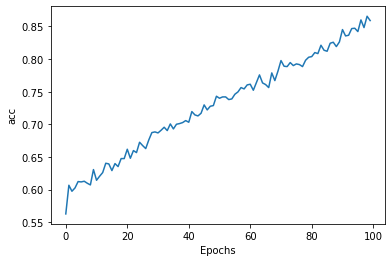

training of model


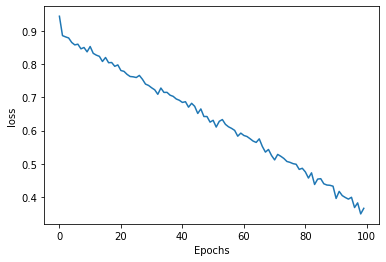

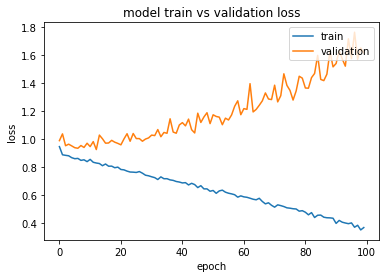

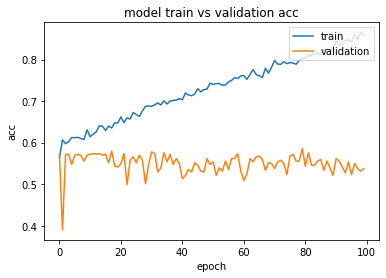

Evaluated on metrics  ['loss', 'acc']
684/684 [==============================] - 1s 2ms/step
Test Loss : 1.5924709386992872 Test Accuracy:  0.5497075915336609

predictions shape is:  (684, 3)


 Predictions into Class Labels: [0 0 1 0 1 0 1 0 0 0 1 0 2 0 1 0 0 0 1 0 1 1 1 0 1 1 2 0 0 1 0 1 1 1 1 1 1
 0 2 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 2 1 2 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0
 2 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 2 2 0 1 1 1 1
 2 1 0 1 2 1 0 2 1 1 1 0 0 2 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 2 1 1 1 2 0 0 2
 2 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 2 1 0
 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 1 0 1 1 1 1 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 2 1 0 0 1 0 1 1 0 1 0 0 1 0 1 2
 2 2 2 2 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 2

In [41]:
# SECOND Stacked Model

# call for embeddings according to new parameters

n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

# print(n1)
# print(n2)
# print(n3)


stacked_n2 = stacked_bilstm_embeddings(n2)
stacked_n3 = stacked_bilstm_embeddings(n3)

print(stacked_n2)
print(stacked_n3)

STACKED_EMBEDDINGS = [stacked_n2, stacked_n3]

model_stacked_bilstm = classification_model(STACKED_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_stacked_bilstm, to_file = 'modelQA_stacked_bilstm.png', show_shapes=True, show_layer_names=True)

history_stacked_bilstm = training_model(model_stacked_bilstm, 'modelQA-stacked-bilstm', TRAIN_FIT, VAL_FIT) 

save_models(model_stacked_bilstm, 'modelQA_stacked_bilstm')

plot_graphs(history_stacked_bilstm, 'acc')
plot_graphs(history_stacked_bilstm, 'loss')
plot_both_graphs(history_stacked_bilstm)

model_predictions_stacked_bilstm, predicted_class_names_stacked_bilstm = evaluate_model(model_stacked_bilstm, TEST_FIT)

result_stacked_bilstm = result_storeQA(predicted_class_names_stacked_bilstm)

print("no of true labels:\n", result_stacked_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_stacked_bilstm.predicted_label.value_counts())

result_stacked_bilstm.head()

results_path = os.getcwd() 
result_stacked_bilstm.to_csv(os.path.join(results_path,'QA-STACKED-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)
